In [2]:
from math import exp, log

import numpy as np
import scipy as sp
from scipy import stats
from scipy.special import expit

import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib notebook

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.charts import HeatMap, bins

%load_ext autoreload
%autoreload 2

output_notebook()

Loading BokehJS ...

In [3]:
np.random.seed(42)

In [4]:
p1 = figure(title="Beta of Disease", background_fill_color="white")

x = np.linspace(0, 1, 1000)
beta_dist = stats.beta(0.5, 1)
rvs = beta_dist.rvs(size=10000)
pdf = beta_dist.pdf(x)

hist, edges = np.histogram(rvs, density=True, bins=50)

p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=None, line_color="#033649")
p1.line(x, pdf, line_color="#D95B43", line_width=2, alpha=0.7, legend="PDF")

p1.legend.location = "top_left"
p1.xaxis.axis_label = 'x'
p1.yaxis.axis_label = 'Pr(x)'

show(p1);

In [5]:
p1 = figure(title="Severity of Disease", background_fill_color="white")

x = np.linspace(0, 1, 1000)
sev_dist = stats.beta(3, 1.5)
rvs = sev_dist.rvs(size=10000)
pdf = sev_dist.pdf(x)

hist, edges = np.histogram(rvs, density=True, bins=50)

p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=None, line_color="#033649")
p1.line(x, pdf, line_color="#D95B43", line_width=2, alpha=0.7, legend="PDF")

p1.legend.location = "top_left"
p1.xaxis.axis_label = 'x'
p1.yaxis.axis_label = 'Pr(x)'

show(p1);

In [6]:
p2 = figure(title="Age in years", background_fill_color="white")

x = np.linspace(0, 100, 1000)
ages_dist = stats.gamma(8, scale=4)
rvs = ages_dist.rvs(size=10000)
pdf = ages_dist.pdf(x)

hist, edges = np.histogram(rvs, density=True, bins=50)

p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=None, line_color="#033649")
p2.line(x, pdf, line_color="#D95B43", line_width=2, alpha=0.7, legend="PDF")

p2.legend.location = "top_left"
p2.xaxis.axis_label = 'x'
p2.yaxis.axis_label = 'Pr(x)'

show(p2);

##### Expected recovery time (days) = $exp(2+0.5*I_{male} + 0.03*age + 0.2*severity - 1*I_{medication})$

# Double-blind A/B test

In [7]:
N = 100000

In [8]:
sexes = np.random.randint(0,2, size=N)  # sex == 1 if male otherwise female
ages = ages_dist.rvs(size=N)
severties = sev_dist.rvs(size=N)
meds = np.random.randint(0,2, size=N)
const = np.ones(N)

In [9]:
df = pd.DataFrame(dict(sex=sexes, age=ages, severity=severties, medication=meds, const=const))
features = ['sex', 'age', 'severity', 'medication', 'const']
df = df[features]
df.head()

,sex,age,severity,medication,const
0,0,47.867880,0.273982,1,1.0
1,0,41.336733,0.734177,1,1.0
2,1,18.604427,0.619975,0,1.0
3,0,18.573527,0.519285,0,1.0
4,1,29.575086,0.920299,1,1.0


In [10]:
df.describe()

,sex,age,severity,medication,const
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.0
mean,0.50163,31.997975,0.665452,0.500510,1.0
std,0.50000,11.316246,0.201821,0.500002,0.0
min,0.00000,3.254063,0.014219,0.000000,1.0
25%,0.00000,23.817265,0.526599,0.000000,1.0
50%,1.00000,30.674723,0.691179,1.000000,1.0
75%,1.00000,38.701425,0.828915,1.000000,1.0
max,1.00000,96.794907,0.999951,1.000000,1.0


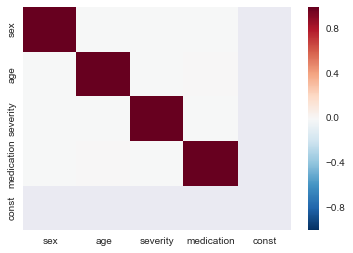

In [11]:
data = df.corr()
sns.heatmap(data)

In [12]:
data.reset_index()

,index,sex,age,severity,medication,const
0,sex,1.000000,-0.000614,-0.001830,-0.007323,NaN
1,age,-0.000614,1.000000,-0.001029,0.002044,NaN
2,severity,-0.001830,-0.001029,1.000000,-0.000230,NaN
3,medication,-0.007323,0.002044,-0.000230,1.000000,NaN
4,const,NaN,NaN,NaN,NaN,NaN


In [13]:
def exp_recovery_time(sex, age, severity, medication):
    return exp(2+0.5*sex+0.03*age+2*severity-1*medication)

In [14]:
def rvs_recovery_time(sex, age, severity, medication, *args):
    return stats.poisson.rvs(exp_recovery_time(sex, age, severity, medication))

In [15]:
exp_recovery_time(1, 50, 0.5, 1)

54.598150033144236

In [16]:
df['recovery'] = df.apply(lambda x: rvs_recovery_time(*x) , axis=1)
df.head()

,sex,age,severity,medication,const,recovery
0,0,47.867880,0.273982,1,1.0,21
1,0,41.336733,0.734177,1,1.0,30
2,1,18.604427,0.619975,0,1.0,69
3,0,18.573527,0.519285,0,1.0,32
4,1,29.575086,0.920299,1,1.0,68


In [17]:
glm = sm.GLM(df['recovery'], df[features], family=sm.families.Poisson())
res = glm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               recovery   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -3.4374e+05
Date:                Fri, 17 Mar 2017   Deviance:                   1.0047e+05
Time:                        16:18:26   Pearson chi2:                 1.00e+05
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4983      0.001    664.959      0.000       0.497       0.500
age            0.0300   2.84e-05   1057.067      0.0

In [18]:
reg = RandomForestRegressor()
X = df[features].as_matrix()
y = df['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
X_neg = np.copy(X)
X_neg[:, df.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
X_pos[:, df.columns.get_loc('medication')] = 1

In [20]:
effect = np.mean(reg.predict(X_pos) / reg.predict(X_neg))

In [21]:
np.log(effect)

-0.99543726156799395

# Now with a bias, likelihood of getting a treatment rises with the severity

In [22]:
def get_medication(sex, age, severity, medication, *args):
    return int(1/3*sex + 2/3*severity + 0.15*np.random.randn() > 0.8)

In [23]:
df2 = df.copy().drop('recovery', axis=1)
df2['medication'] = df2.apply(lambda x: get_medication(*x), axis=1)
df2['recovery'] = df2.apply(lambda x: rvs_recovery_time(*x), axis=1)
df2.describe(percentiles=np.arange(0.1,1,0.1))

,sex,age,severity,medication,const,recovery
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000
mean,0.50163,31.997975,0.665452,0.248960,1.0,85.193510
std,0.50000,11.316246,0.201821,0.432413,0.0,53.118433
min,0.00000,3.254063,0.014219,0.000000,1.0,4.000000
10%,0.00000,18.631135,0.377623,0.000000,1.0,35.000000
20%,0.00000,22.281734,0.484453,0.000000,1.0,45.000000
30.0%,0.00000,25.226576,0.563745,0.000000,1.0,54.000000
40%,0.00000,27.973471,0.630517,0.000000,1.0,63.000000
50%,1.00000,30.674723,0.691179,0.000000,1.0,72.000000
60%,1.00000,33.569405,0.747098,0.000000,1.0,84.000000


In [24]:
df2['medication'].sum()/df2['medication'].count()

0.24895999999999999

In [25]:
df2.corr()

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.000614,-0.001830,0.501629,NaN,0.067433
age,-0.000614,1.000000,-0.001029,-0.001850,NaN,0.616756
severity,-0.001830,-0.001029,1.000000,0.346984,NaN,0.376738
medication,0.501629,-0.001850,0.346984,1.000000,NaN,-0.269800
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.067433,0.616756,0.376738,-0.269800,NaN,1.000000


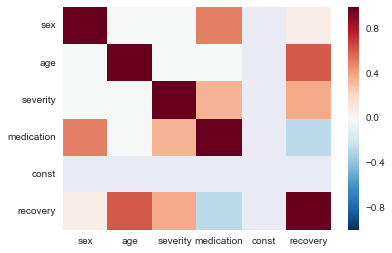

In [26]:
data = df2.corr()
sns.heatmap(data)

In [27]:
glm = sm.GLM(df2['recovery'], df2[features], family=sm.families.Poisson())
res = glm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               recovery   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -3.5619e+05
Date:                Fri, 17 Mar 2017   Deviance:                       99912.
Time:                        16:18:43   Pearson chi2:                 9.96e+04
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5008      0.001    648.405      0.000       0.499       0.502
age            0.0300   2.68e-05   1120.665      0.0

In [28]:
reg = RandomForestRegressor()
X2 = df2[features].as_matrix()
y2 = df2['recovery'].values
reg.fit(X2, y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
X2_neg = np.copy(X2)
X2_neg[:, df.columns.get_loc('medication')] = 0
X2_pos = np.copy(X2)
X2_pos[:, df.columns.get_loc('medication')] = 1

In [30]:
effect = np.mean(reg.predict(X2_pos) / reg.predict(X2_neg))

In [31]:
np.log(effect)

-0.73975207187503045

### Oooppss, wrong coefficients!

# Let's use the propensity score

In [32]:
features

['sex', 'age', 'severity', 'medication', 'const']

In [33]:
#cls = RandomForestClassifier()
cls = LogisticRegression(random_state=42)
cls = GaussianNB()
#cls = LinearSVC()

cls = CalibratedClassifierCV(cls)

X3 = df2[features].drop(['medication'], axis=1).as_matrix()
y3 = df2['medication'].values
cls.fit(X3, y3)

CalibratedClassifierCV(base_estimator=GaussianNB(priors=None), cv=3,
            method='sigmoid')

In [34]:
propensity = pd.DataFrame(cls.predict_proba(X3))
propensity[propensity[0]==0.] = 1e-3
propensity[propensity[1]==0.] = 1e-3

In [35]:
sp.stats.describe(propensity.lookup(np.arange(propensity.shape[0]), df2['medication'].values))

DescribeResult(nobs=100000, minmax=(0.035050284280100603, 0.96495204328689888), mean=0.7915059677544275, variance=0.060933318347452289, skewness=-1.3915461588091262, kurtosis=0.9533337504129751)

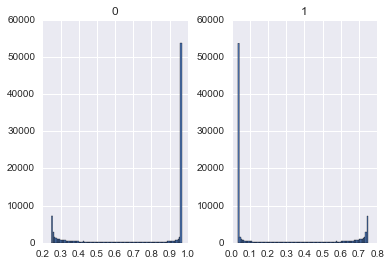

In [36]:
propensity.hist(bins=100);

In [37]:
propensity.describe()

,0,1
count,100000.000000,100000.000000
mean,0.751025,0.248975
std,0.287916,0.287916
min,0.249665,0.035048
25%,0.432116,0.035158
50%,0.964706,0.035294
75%,0.964842,0.567884
max,0.964952,0.750335


In [38]:
df2['iptw'] = 1. / propensity.lookup(np.arange(propensity.shape[0]), df2['medication'])

In [39]:
propensity.lookup(np.arange(propensity.shape[0]), df2['medication'])[:20]

array([ 0.9649514 ,  0.96480783,  0.60766305,  0.96492793,  0.75014307,
        0.26845362,  0.74781107,  0.96472997,  0.27041014,  0.96485355,
        0.96450514,  0.7128408 ,  0.964951  ,  0.96486114,  0.74619394,
        0.74854896,  0.95288138,  0.96493588,  0.96474302,  0.25094783])

In [40]:
df2.describe()

,sex,age,severity,medication,const,recovery,iptw
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000
mean,0.50163,31.997975,0.665452,0.248960,1.0,85.193510,1.977283
std,0.50000,11.316246,0.201821,0.432413,0.0,53.118433,3.709590
min,0.00000,3.254063,0.014219,0.000000,1.0,4.000000,1.036321
25%,0.00000,23.817265,0.526599,0.000000,1.0,50.000000,1.036440
50%,1.00000,30.674723,0.691179,0.000000,1.0,72.000000,1.038082
75%,1.00000,38.701425,0.828915,0.000000,1.0,106.000000,1.425735
max,1.00000,96.794907,0.999951,1.000000,1.0,992.000000,28.530439


In [41]:
glm = sm.GLM(df2['recovery'], df2[features], family=sm.families.Poisson(), freq_weights=df2['iptw'] )
res = glm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               recovery   No. Observations:               100000
Model:                            GLM   Df Residuals:                   197723
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -6.8647e+05
Date:                Fri, 17 Mar 2017   Deviance:                   1.9453e+05
Time:                        16:18:49   Pearson chi2:                 1.94e+05
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4997      0.001    943.368      0.000       0.499       0.501
age            0.0300   1.99e-05   1506.607      0.0

In [42]:
reg = RandomForestRegressor(random_state=42)
X4 = df2[features].as_matrix()
y4 = df2['recovery'].values
reg.fit(X4, y4, sample_weight=df2['iptw'].values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [43]:
X4_neg = np.copy(X4)
X4_neg[:, df.columns.get_loc('medication')] = 0
X4_pos = np.copy(X4)
X4_pos[:, df.columns.get_loc('medication')] = 1

In [44]:
effect = np.mean(reg.predict(X4_pos) / reg.predict(X4_neg))

In [45]:
np.log(effect)

-0.92439535624121794